<a href="https://colab.research.google.com/github/thaCripple/simple-ANNs-pytorch/blob/main/%20/Simple_Mutliclass_Classification/Multiclass_Classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Multiclass classification Problem with PyTorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

# Create the data

In [2]:
from sklearn.datasets import make_blobs

In [113]:
x, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.61, random_state=13)

In [4]:
np.unique(ar=y, return_counts=True)

(array([0, 1, 2, 3]), array([250, 250, 250, 250]))

In [5]:
x.shape

(1000, 2)

In [6]:
y.shape

(1000,)

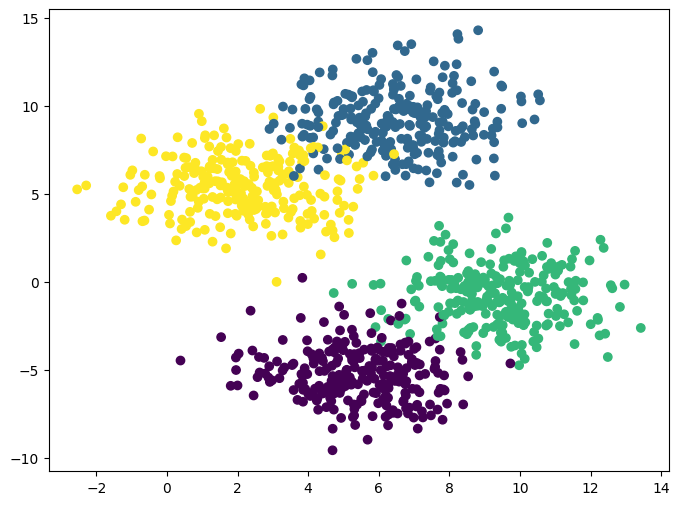

In [114]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x[:,0], x[:,1], c=y)
fig.show()

## Split the data into training and testing subsets

In [8]:
from sklearn.model_selection import train_test_split

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [116]:
x_train_tens = torch.from_numpy(x_train).to(dtype=torch.float32)
y_train_tens = torch.from_numpy(y_train).to(dtype=torch.int64) # CrossEntropyLoss requires the true labels to be int64 dtype

x_test_tens = torch.from_numpy(x_test).to(dtype=torch.float32)
y_test_tens = torch.from_numpy(y_test).to(dtype=torch.int64) # CrossEntropyLoss requires the true labels to be int64 dtype

## Create pytorch dataloaders

In [117]:
train_ds = torch.utils.data.TensorDataset(x_train_tens, y_train_tens)
train_data = torch.utils.data.DataLoader(dataset=train_ds, batch_size=32, shuffle=True)

test_ds = torch.utils.data.TensorDataset(x_test_tens, y_test_tens)
test_data = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32, shuffle=False)

# Define the Model

In [118]:
class MultiModel(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.sequence = nn.Sequential(
        nn.Linear(in_features=2, out_features=8), # 2 features: x-coordinate and y-coordinate
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=4), # 4 classes
    )

  def forward(self, x):
    return self.sequence(x)

In [119]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [120]:
model0 = torch.compile(MultiModel()).to(device=device)

## Specify the loss function and optimizer

In [121]:
loss_fn = nn.CrossEntropyLoss() # Works with logits
optimizer = torch.optim.Adam(params=model0.parameters(), lr=.01)

## Let's try using torchmetrics' accuracy function

In [16]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [17]:
import torchmetrics

# Define the training and testing functions

In [122]:
@torch.compile
def train(model, train_data, loss_fn, optimizer):
  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(train_data)

  model.train()
  for x_batch, y_batch in train_data:
    x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)

    y_logits = model(x_batch)
    loss = loss_fn(y_logits, y_batch)
    total_epoch_loss += loss

    y_pred = torch.softmax(y_logits, dim=1)
    accuracy = torchmetrics.functional.classification.multiclass_accuracy(preds=y_pred, target=y_batch, num_classes=4)
    total_epoch_accuracy += accuracy

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches
  print(f"Train Loss: {mean_epoch_loss:.4f} | Train Accuracy: {mean_epoch_accuracy:.2f}")
  return mean_epoch_loss, mean_epoch_accuracy

@torch.compile
def test(model, test_data, loss_fn):
  total_epoch_loss = 0
  total_epoch_accuracy = 0
  num_batches = len(test_data)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_data:
      x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)

      y_logits = model(x_batch)
      loss = loss_fn(y_logits, y_batch)
      total_epoch_loss += loss

      y_pred = torch.softmax(y_logits, dim=1)
      accuracy = torchmetrics.functional.classification.multiclass_accuracy(preds=y_pred, target=y_batch, num_classes=4)
      total_epoch_accuracy += accuracy

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_accuracy = total_epoch_accuracy / num_batches
  print(f"Test Loss: {mean_epoch_loss:.4f} | Test Accuracy: {mean_epoch_accuracy:.2f}")
  return mean_epoch_loss, mean_epoch_accuracy

In [20]:
# test(model=model0, test_data=test_data, loss_fn=loss_fn)

In [123]:
EPOCHS = 20

In [124]:
train_metrics = []
test_metrics = []

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}/{EPOCHS}")
  train_metrics.append(train(model=model0, train_data=train_data, loss_fn=loss_fn, optimizer=optimizer))
  test_metrics.append(test(model=model0, test_data=test_data, loss_fn=loss_fn))
  print("\n")

Epoch 0/20
Train Loss: 0.9756 | Train Accuracy: 0.63
Test Loss: 0.4442 | Test Accuracy: 0.91


Epoch 1/20
Train Loss: 0.3033 | Train Accuracy: 0.91
Test Loss: 0.2697 | Test Accuracy: 0.82


Epoch 2/20
Train Loss: 0.2341 | Train Accuracy: 0.90
Test Loss: 0.1328 | Test Accuracy: 0.94


Epoch 3/20
Train Loss: 0.1497 | Train Accuracy: 0.95
Test Loss: 0.1473 | Test Accuracy: 0.92


Epoch 4/20
Train Loss: 0.1197 | Train Accuracy: 0.96
Test Loss: 0.1022 | Test Accuracy: 0.95


Epoch 5/20
Train Loss: 0.1123 | Train Accuracy: 0.96
Test Loss: 0.0894 | Test Accuracy: 0.93


Epoch 6/20
Train Loss: 0.1097 | Train Accuracy: 0.96
Test Loss: 0.0945 | Test Accuracy: 0.93


Epoch 7/20
Train Loss: 0.0985 | Train Accuracy: 0.96
Test Loss: 0.0715 | Test Accuracy: 0.98


Epoch 8/20
Train Loss: 0.0901 | Train Accuracy: 0.97
Test Loss: 0.1377 | Test Accuracy: 0.93


Epoch 9/20
Train Loss: 0.1005 | Train Accuracy: 0.96
Test Loss: 0.3317 | Test Accuracy: 0.88


Epoch 10/20
Train Loss: 0.1419 | Train Accuracy: 0

## Extract the training history statistics

In [125]:
train_loss_hist = []
train_accuracy_hist = []
for item in train_metrics:
  train_loss_hist.append(item[0].item())
  train_accuracy_hist.append(item[1].item())

test_loss_hist = []
test_accuracy_hist = []
for item in test_metrics:
  test_loss_hist.append(item[0].item())
  test_accuracy_hist.append(item[1].item())

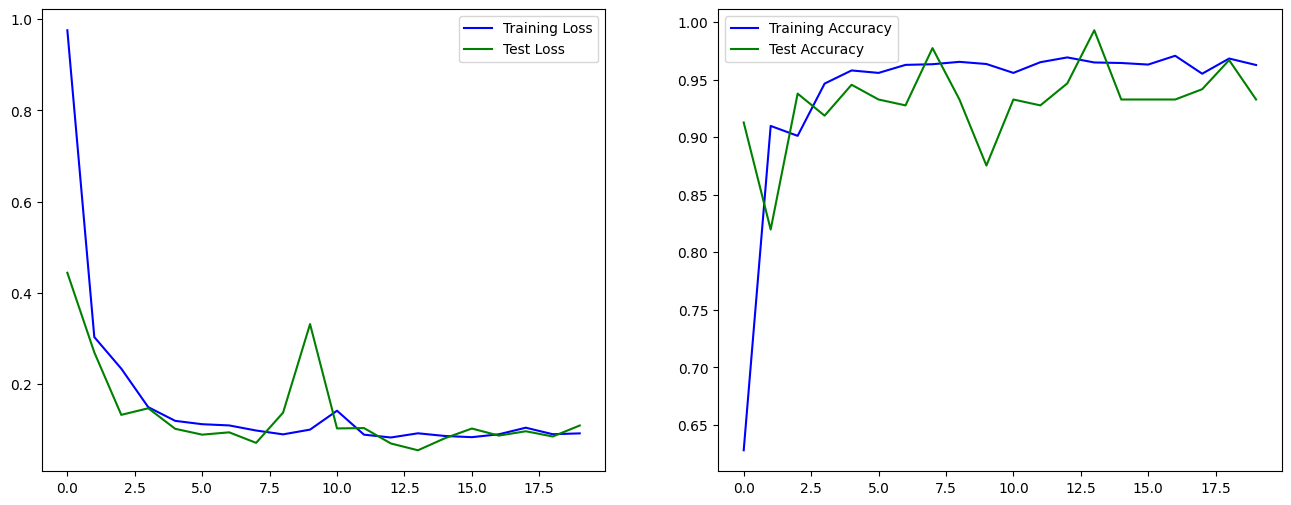

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(train_loss_hist, label="Training Loss", c="blue")
ax[0].plot(test_loss_hist, label="Test Loss", c="green")
ax[0].legend()

ax[1].plot(train_accuracy_hist, label="Training Accuracy", c="blue")
ax[1].plot(test_accuracy_hist, label="Test Accuracy", c="green")
ax[1].legend()

fig.show()

# Evaluate the model

In [127]:
model0.eval()
with torch.inference_mode():
  model0_test_logits = model0(x_test_tens.to(device=device))

In [128]:
model0_test_logits[:4]

tensor([[ -2.2072,  -0.4228,  -5.9630,   5.6137],
        [ -2.8496,   0.4065,  -7.7336,   6.6945],
        [ 10.3541, -12.8380,   0.6354,  -8.3166],
        [ -6.2057,   9.1948,  -3.2196,   2.4518]], device='cuda:0')

In [129]:
model0_test_predictions = model0_test_logits.argmax(dim=1)

In [130]:
model0_test_predictions[:4]

tensor([3, 3, 0, 1], device='cuda:0')

In [131]:
y_test_tens[:4]

tensor([3, 3, 0, 1])

In [132]:
from sklearn.metrics import classification_report

In [133]:
print(classification_report(y_true=y_test_tens.to(device="cpu").numpy(), y_pred=model0_test_predictions.to(device="cpu").numpy()))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.90      1.00      0.95        38
           2       0.96      1.00      0.98        51
           3       1.00      0.90      0.95        51

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200

